# Plot for the paper

In [5]:
results_folder = './paper_plot_data/'

## Import Packages

In [40]:
import os
import sys
import numpy as np
import pandas as pd
import time
from looti import dictlearn as dcl
from looti import datahandle as dhl
from looti import PlottingModule as pm
from looti import tools as too
from looti import PlottingModule as pm

import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Simple example (CDE) plot prediction and training vector

In [7]:
data_folder = '../../SimulationData/CDE_fitting_formulae/'
###Name of the file for the external input data, without the extension
datafile_ext = 'EXP_Pk_32_betas_60_redzs'
###Name of the file for the LCDM input data
datafile_ref = 'LCDM_Pk_60_redzs'
emulation_data = dhl.DataHandle( datafile_ext, data_folder, datafile_ref, num_parameters=1) 
emulation_data.read_csv_pandas() 
emulation_data.set_level_of_noise("noise_100")
emulation_data.calculate_ratio_by_redshifts(emulation_data.z_vals, normalize=False)

/Users/raphaelbaena/Stage/looti-test-public/looti/datahandle.py:245: PerformanceWarning: indexing past lexsort depth may impact performance.
  for iind in (self.df_ext.loc[nnoi,z_request].index):


In [38]:
emulation_data.calculate_data_split(n_train=6, ##number of training vectors/ redshift
                                    n_test=1, ##number of test vectors
                                    verbosity=1,
                                    manual_split=True,
                                    test_indices = [17],
                                    train_redshift_indices=[0],##Indices of the redshifts used for the train vect.
                                    test_redshift_indices=[0]) ##Indices of the redshifts used for the test vect.

('number of wanted test vectors', 1)
('redshift used for training', array([0.]))
('redshfit used for testing', array([0.]))


/Users/raphaelbaena/Stage/looti-test-public/looti/datahandle.py:336: PerformanceWarning: indexing past lexsort depth may impact performance.
  for iind in (self.df_ext.loc[self.noiseless_str,z].index):


('Shape of PCA matrix: (8, 5)',)
('Number of PCA components: 5',)


(array([0.9997219 , 0.99946932, 0.99916662, ..., 0.9719234 , 0.97188215,
        0.97184091]),
 array([1.01245575, 0.99536962, 0.98999137, ..., 0.97238548, 0.97223358,
        0.97232025]))

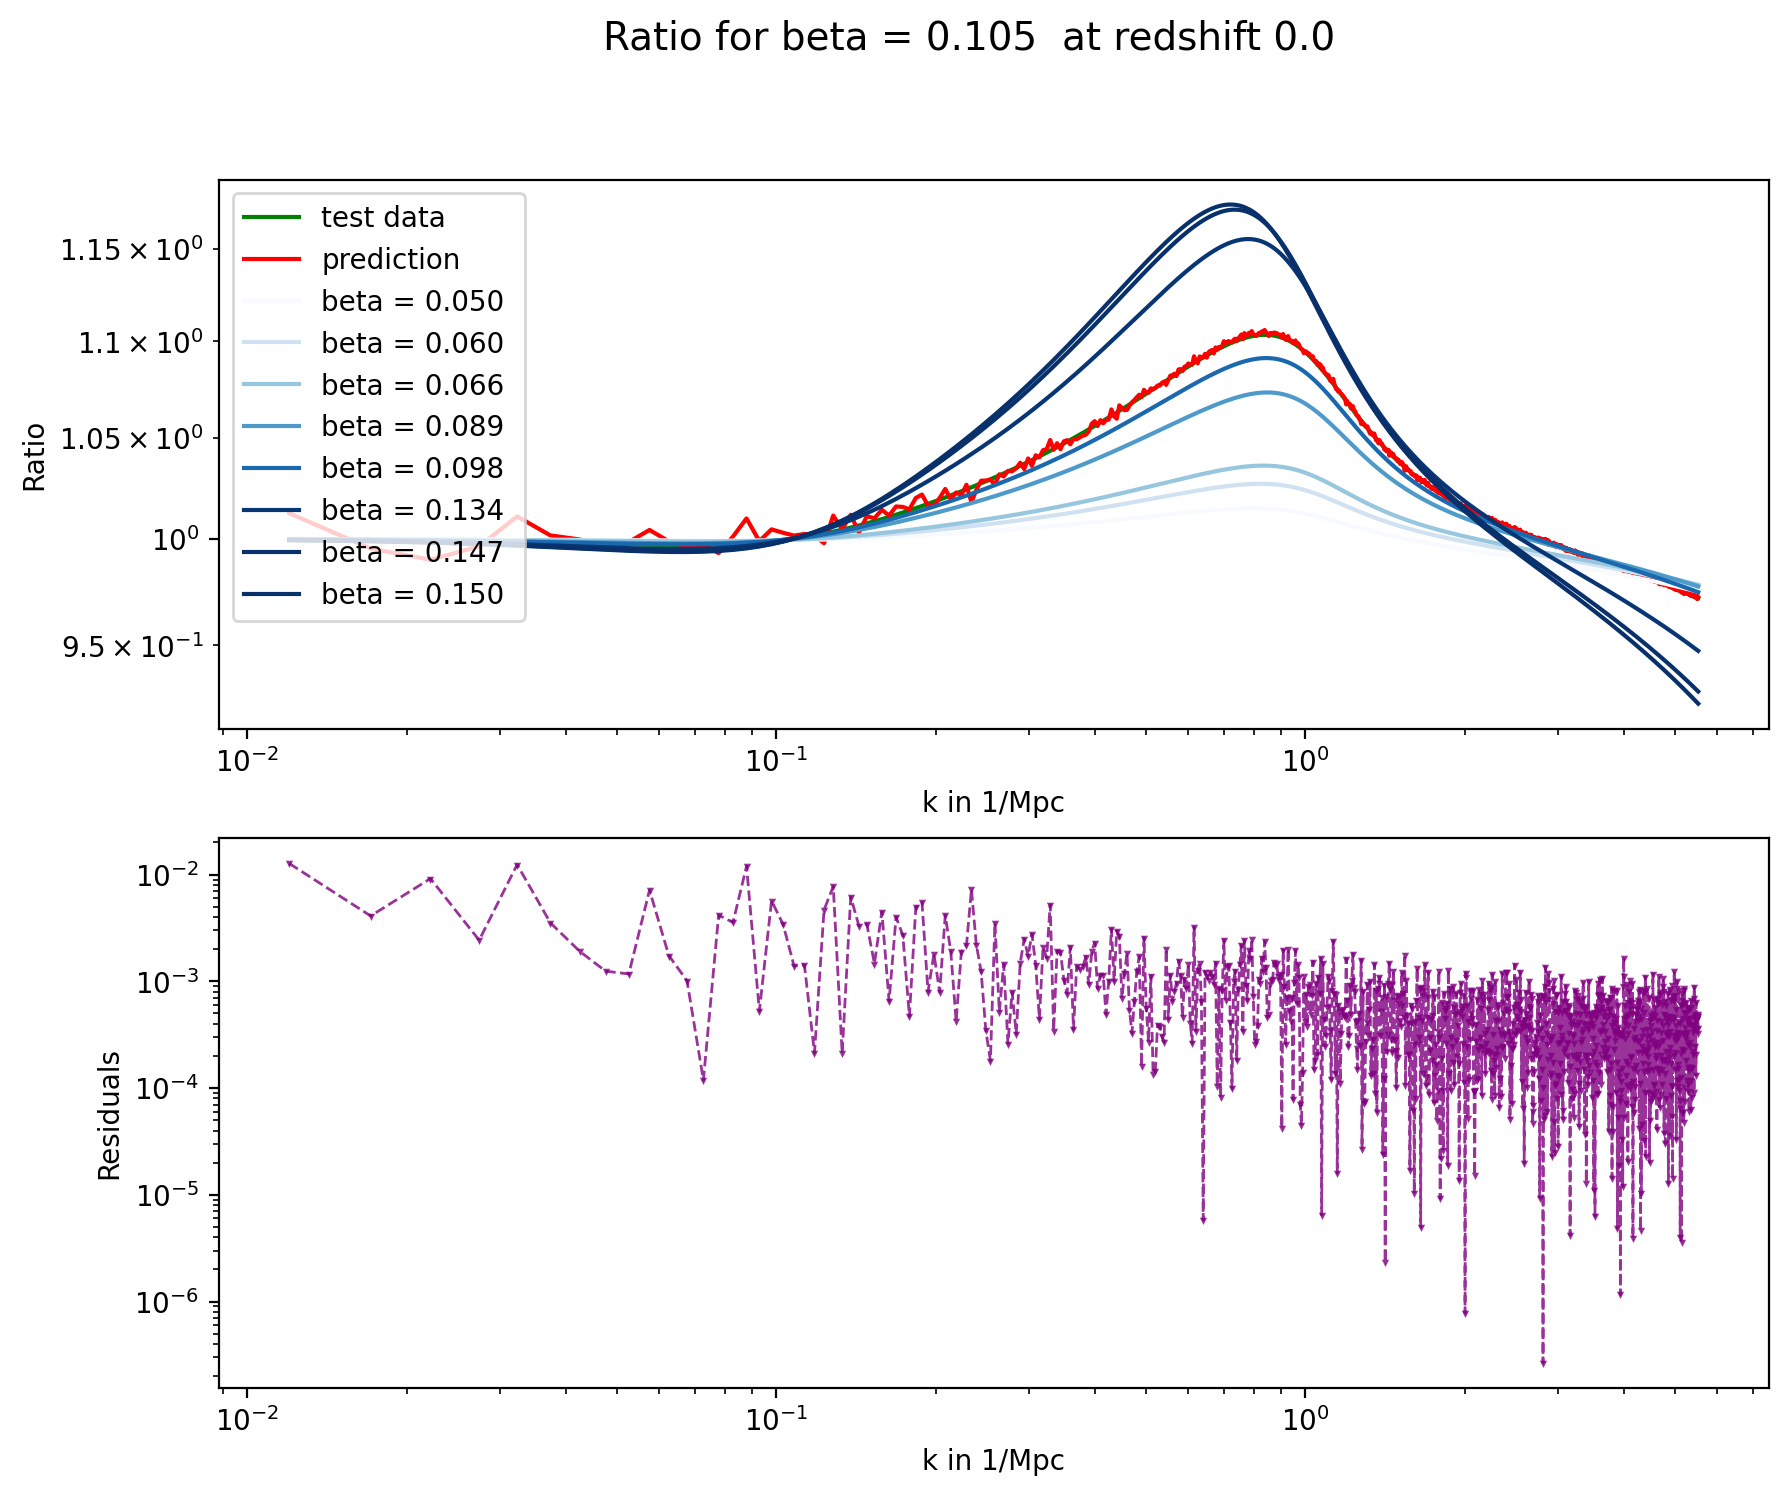

In [41]:
npca = 5 
ratios_predicted , emulation_data = dcl.Predict_ratio(emulation_data,Operator = "PCA",
                                                      train_noise = 1e-3, ##noise for the GP's kernel
                                                      gp_n_rsts = 10,##times allowed to restart the optimiser
                                                      ncomp=npca , ##number of components
                                                      gp_const = 1, ##Constant for the RBF kernel
                                                      gp_length = 1 , ## Length for  GP 
                                                      interp_type='GP', ##kind of interpolator,e.g int1d or GP 
                                                     min_k =1e-2,max_k=10e1)
pm.Plot_prediction_One_parameter(emulation_data,0.13387097,ratios_predicted, y_scale_log=True,plot_training_vectors=True,
                                save_path=results_folder,name_of_plot="simple_example_train_and_tests_vectors")
              

# Representation

('Shape of PCA matrix: (14, 2)',)
('Number of PCA components: 2',)
('Shape of PCA matrix: (14, 2)',)
('Number of PCA components: 2',)


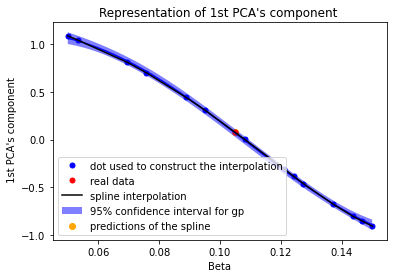

In [96]:
#Indices of the redshifts used for the test vect.
npca = 2
component  = 0

ratios_predicted , emulation_data,interpolator_spline = dcl.Predict_ratio(emulation_data,Operator = "PCA", ##choose the operator
                                                      ncomp=npca ,  ##number of components
                                                      interp_type='int1d',interp_dim =1,return_interpolator=True ##kind of interpolator,e.g int1d or GP 
                                                     )

ratios_predicted , emulation_data,interpolator_gp = dcl.Predict_ratio(emulation_data,Operator = "PCA",
                                                      train_noise = 1e-1, ##noise for the GP's kernel
                                                      gp_n_rsts = 10,##times allowed to restart the optimiser
                                                      ncomp=npca , ##number of components
                                                      gp_const = 1, ##Constant for the RBF kernel
                                                      gp_length = 1 , ## Length for  GP 
                                                      interp_type='GP', ##kind of interpolator,e.g int1d or GP 
                                                                      return_interpolator=True)

import numpy as np
#samples = np.vstack((emulation_data.test_samples,emulation_data.train_samples));
#samples= np.sort(samples,axis=0)
samples=np.zeros((1000,2))
samples[:,0] = np.zeros(1000)
samples[:,1] = np.linspace(0.05,0.15,1000)
interpolator_spline.interpolated_atoms(samples[:,1])
#samples =emulation_data.train_samples
interpolation_gp,sigma=interpolator_gp.gp_regressor.predict(samples,return_std=True)





samples_one_d = samples [:,1 ]

representation_test = interpolator_spline.pca.transform(emulation_data.matrix_datalearn_dict["theo"]["test"])
interpolation_test = interpolator_spline.interpolated_atoms(emulation_data.test_samples[:,-1 ].flatten())

plt.plot(emulation_data.train_samples[:,1 ] , interpolator_gp.pca.transform(emulation_data.matrix_datalearn_dict["theo"]["train"])[:,component ],'b.',markersize=10,label ="dot used to construct the interpolation")
plt.plot(emulation_data.test_samples[:,1] , interpolator_gp.pca.transform(emulation_data.matrix_datalearn_dict["theo"]["test"])[:,component ],'r.',markersize=10, label = "real data")




plt.scatter(emulation_data.test_samples[:,1],interpolation_test [:,component ],color = 'orange', label ="predictions of the spline")
plt.plot(samples_one_d , interpolation_gp[:,component],'b-')
plt.plot(samples_one_d,interpolator_spline.interpolated_atoms(samples[:,1 ])[:,component ],color = 'black',label = "spline interpolation")
plt.fill(np.concatenate([samples_one_d, samples_one_d[::-1]]),
        np.concatenate([interpolation_gp[:,component ] - 2/np.sqrt(5) * sigma,
                     (interpolation_gp[:,component ] +2/np.sqrt(5) * sigma)[::-1]]), alpha=.5, fc='b', ec='None', label='95% confidence interval for gp')



plt.title("Representation of 1st PCA's component ")
plt.xlabel("Beta")
plt.ylabel(" 1st PCA's component")
plt.legend()
plt.savefig(results_folder+"Representation_1st_component.jpg")

No handles with labels found to put in legend.


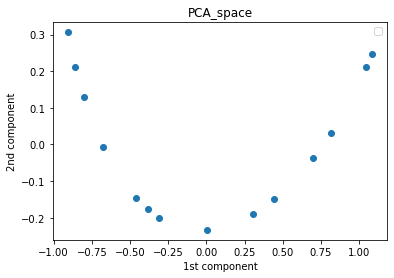

In [99]:
plt.title("PCA_space")

plt.scatter(interpolator_gp.pca.transform(emulation_data.matrix_datalearn_dict["theo"]["train"])[:,0],
            interpolator_gp.pca.transform(emulation_data.matrix_datalearn_dict["theo"]["train"])[:,1])
plt.xlabel("1st component")
plt.ylabel("2nd component")
plt.legend()
plt.savefig(results_folder+"PCA_space.jpg")

# Latin Hypercube Massive Nus

Text(0.5, 0, '$A_s$')

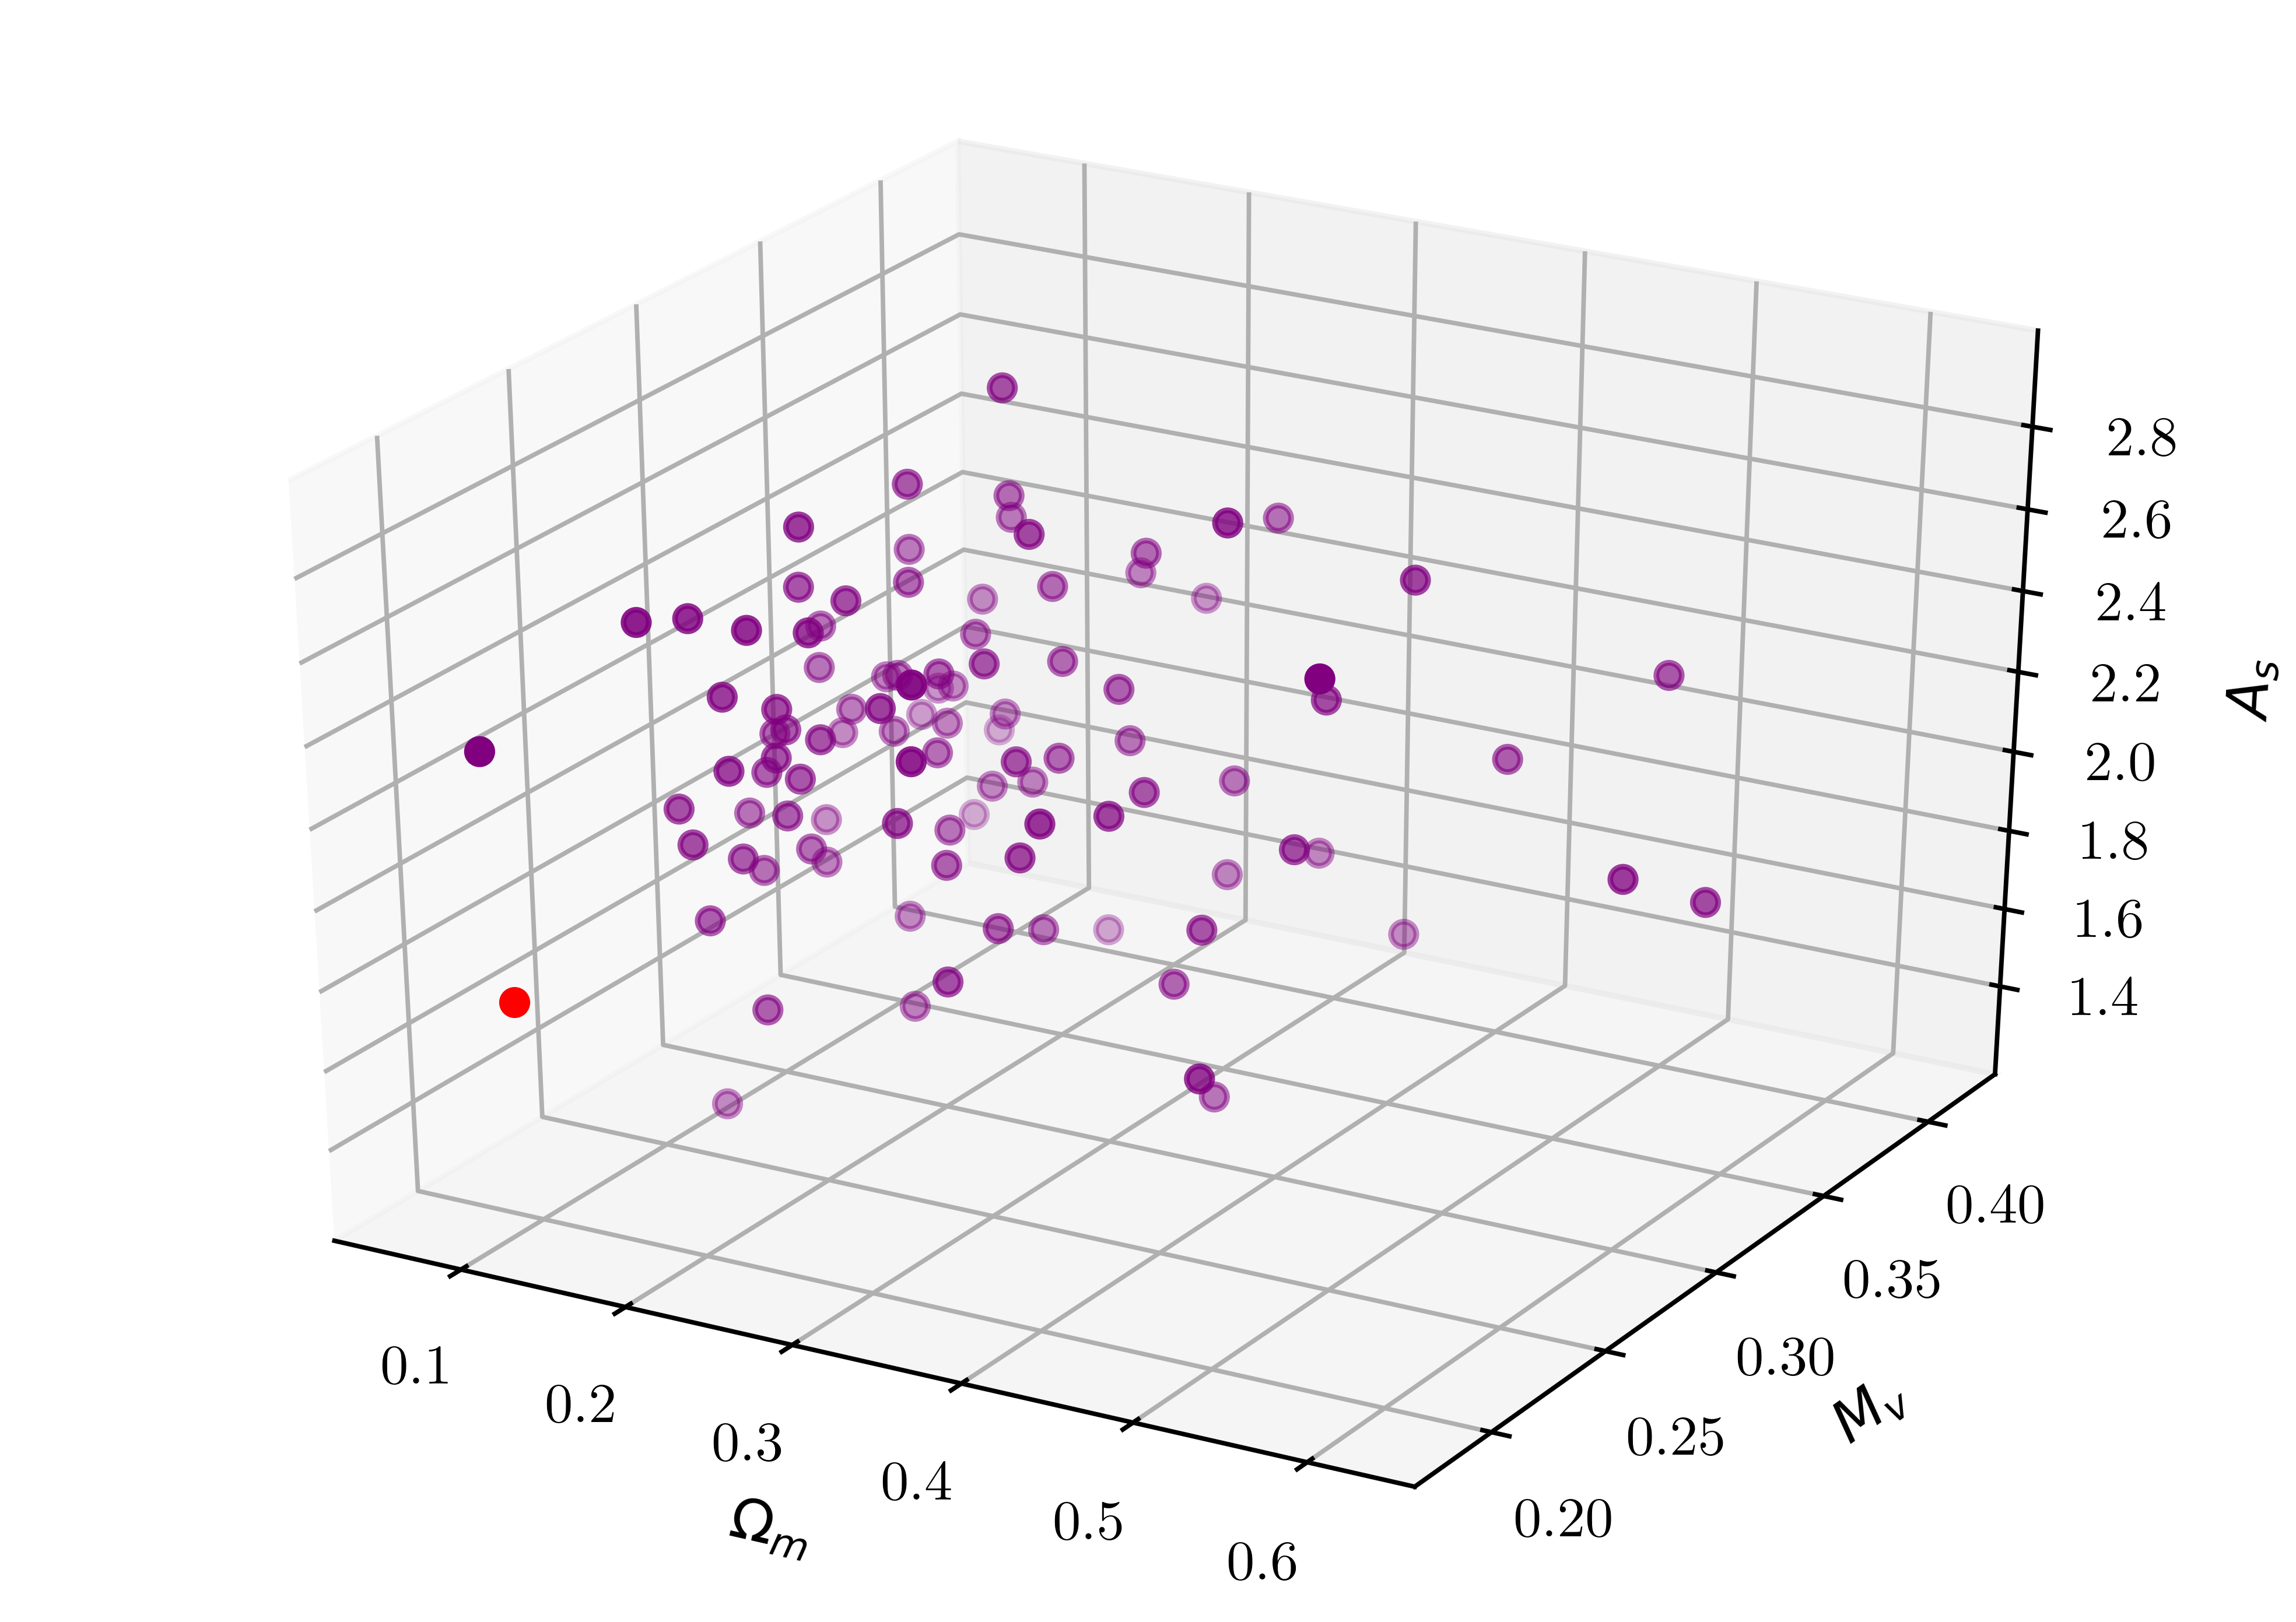

In [100]:
data_folder = '../../SimulationData/Massive_Nus/'
results_folder = './results/'
###Name of the file for the external input data, without the extension
datafile_ext = 'Massive_Nus'
###Name of the file for the LCDM input data
datafile_ref = 'Massive_Nus_LCDM'

emulation_data = dhl.DataHandle( datafile_ext, data_folder, datafile_ref, num_parameters=3) 
emulation_data.read_csv_pandas() 


## First argument contains all the redshifts at which simulations are available
emulation_data.calculate_ratio_by_redshifts(emulation_data.z_vals,normalize=True)

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
param= emulation_data.extparam_vals
fig = plt.figure(figsize=(7,5),dpi=700)
plt.rcParams["font.family"] = "Times New Roman"
ax = fig.add_subplot(111, projection='3d')
ax.scatter(param[21][0],param[21][1],param[21][2],color ="red")
plt.rc('text', usetex=True)
ax.scatter(param[:21,0],param[:21,1],param[:21,2],color ="purple")
ax.scatter(param[22:,0],param[22:,1],param[22:,2],color ="purple")

ax.set_xlabel("$\Omega_m$")
ax.set_ylabel("$M_v$")
ax.set_zlabel("$A_s$")